# Fruit multiclassification

- Fabio Villa ()
- Luca Perfetti ()
- Francesco Cavallini (920835)

Volgiamo realizzare un progetto che, letto un [dataset contenente diversi istanze di frutti ripotati di 360](https://www.kaggle.com/datasets/moltean/fruits/code), implementi un modello di rete neurale (basato su CNN) che permetta la multi calssificazione dei vari gruppi di frutta.fornita. Ossia, più nello specifico, vogliamo creare diverse istanze di reti neurali (sotto forma modalità trial and error) per arrivare a vedere quali sono le performmance più realistiche possibiili che possiamo ottenere addestrando una rete neurale per predirre due label; dove le label in questione rappresentano:
- label 1: categoria generale di frutto (eg: "apple")
- label 2: sotto-categoria di frutto (eg: "apple golden", "apple red", ...)


## Setup

Semplice sezione di setup delle librerie e del dirve

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as mpimg
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from PIL import ImageEnhance
import random

import logging
from numpy.random import RandomState
from sklearn import cluster, decomposition
from sklearn.datasets import fetch_lfw_people
import seaborn as sns
import tensorflow as tf
from tensorflow.data import Dataset

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np
from keras.layers import Input, Lambda
from tensorflow.keras.models import load_model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import MobileNet
import cv2

rng = RandomState(0)

## Lettura dataset

Dalla documentazione si evice che il dataset a nostra disposizione contiene 141 istanze di diversi frutti che vengono fatti ruotare di 360 gradi. Ma si nota che i dati a nostra disposizione non sono perfettamente integri, per questo motivo i dati vengono modificati manualmente (eliminando circa 20 classi) per garantire l'integrità dei dati. Questo step verrà meglio spiegto nella relazione. 

Di seguito procediamo con la lettura del dataset che abbiamo mantenuto:

In [3]:
dataset_path = 'Dataset\\'

### Setup dei dictionaries

Inizializzazione di dictionary che associa labels_2 (eg: "apple golden") ad un numero intero

In [14]:
# Initialize dictionaries
labels_2_int = {}
labels_2_array = []
labels_1_array = []

# Iterate over the subdirectories
for i, folder_name in enumerate(os.listdir(dataset_path+"val\\")):
    # Map folder name to an integer
    folder_name = folder_name[:-2]
    if(len( folder_name.split(' ') ) == 1):
        folder_name = folder_name.split(' ')[0] + " Undefined"
    print(folder_name)

    labels_2_int[folder_name] = i
    labels_2_array.append(folder_name)
    
    if(labels_1_array.__contains__(folder_name.split(' ')[0]) == False):
        # Map the first part of the folder name to an integer
        labels_1_array.append(folder_name.split(' ')[0])

Apple undefined
Apple Braeburn
Apple Crimson Snow
Apple Golden
Apple Golden
Apple Golden
Apple Granny Smith
Apple hit
Apple Pink Lady
Apple Red
Apple Red
Apple Red
Apple Red Delicious
Apple Red Yellow
Apple Red Yellow
Apricot undefined
Avocado undefined
Avocado ripe
Banana undefined
Banana Lady Finger
Banana Red
Beetroot undefined
Blueberry undefined
Cabbage white
Cactus fruit
Cantaloupe undefined
Cantaloupe undefined
Carambula undefined
Carrot undefined
Cauliflower undefined
Cherry undefined
Cherry undefined
Cherry Rainier
Cherry Wax Black
Cherry Wax Red
Cherry Wax Yellow
Chestnut undefined
Clementine undefined
Cocos undefined
Corn undefined
Corn Husk
Cucumber undefined
Cucumber undefined
Cucumber Ripe
Cucumber Ripe
Dates undefined
Eggplant undefined
Eggplant long
Fig undefined
Ginger Root
Granadilla undefined
Grape Blue
Grape Pink
Grape White
Grape White
Grape White
Grape White
Grapefruit Pink
Grapefruit White
Guava undefined
Hazelnut undefined
Huckleberry undefined
Kaki undefined
Ki

Inizializzazione di un dictionary che associa labels_1 (eg: "appple") ad un numero intero

In [6]:
labels_1_int = {}
for i, fruit_name in enumerate(labels_1_array):
    # Map folder name to an integer
    labels_1_int[fruit_name] = i

Questi due dictionaries sono poi utili alla lettura del dataset, siccome, con questi possiamo assegnare ad ogni classe un intero

### Creazione dei file numpy array

#### Funzioni di modifica immagini

Siccome si ha che ogni cartella è formata da sample dello stesso oggetto frutto ma ruotato di 360 gradi, si riconosce che trainare su un dataset del genere porterebbe ad apprendere solo determinate feature di quell'ogetto ma i vari modelli non imparerebbero a generalizzare. Per questo motivo si decide di creare una seri di funzioni che inseriscono delle distorsioni dell'imagnine campione originale all'interno del dataset. Alcune di queste sono:

In [5]:
img = load_img("TrainingFabio_Extracted_data\\test\Apple Braeburn\\2_100.jpg", target_size=(128, 128)) 

--------

In [6]:
def random_flip(img):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Randomly decide whether to flip along x-axis and/or y-axis
    flip_x = np.random.choice([True, False])
    flip_y = np.random.choice([True, False])
    
    if flip_x:
        img_array = np.flip(img_array, axis=1)
    if flip_y:
        img_array = np.flip(img_array, axis=0)
    
    # Convert the numpy array back to a PIL image
    flipped_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return flipped_img

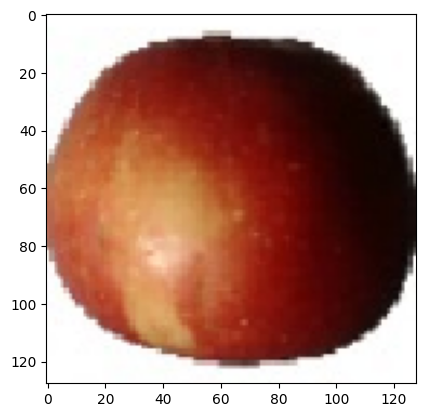

In [7]:
plt.imshow(random_flip(img))

--------

In [8]:
def translate_image(img, max_translation=60):
    # Converti l'immagine in un array numpy
    img_array = np.array(img)
    
    # Genera traslazioni casuali per x e y
    tx = np.random.randint(-max_translation, max_translation + 1)
    ty = np.random.randint(-max_translation, max_translation + 1)
    
    # Crea una nuova immagine bianca con le stesse dimensioni
    translated_img = Image.new('RGB', img.size, (255, 255, 255))
    
    # Calcola le coordinate di incollaggio
    x_offset = max(0, tx)
    y_offset = max(0, ty)
    
    # Incolla l'immagine originale nella nuova immagine traslata
    translated_img.paste(img, (x_offset, y_offset))
    
    # Ritaglia l'immagine per mantenere le dimensioni originali
    translated_img = translated_img.crop((0, 0, img.size[0], img.size[1]))
    
    return translated_img

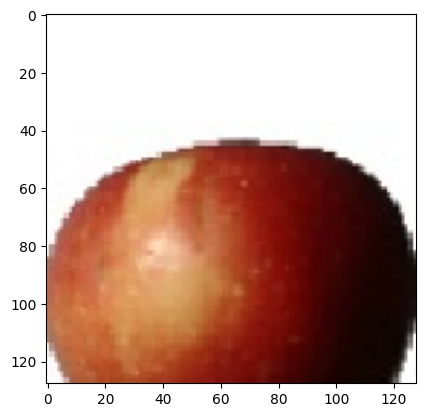

In [9]:
plt.imshow(translate_image(img))

------

In [10]:
def random_brightness(img, min_factor=0.9, max_factor=1.3):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Generate a random brightness factor
    brightness_factor = np.random.uniform(min_factor, max_factor)
    
    # Adjust the brightness, but do not modify pixels with value 255
    img_array = np.where(img_array < 24, np.clip(img_array * brightness_factor, 0, 255), img_array)
    
    # Convert the numpy array back to a PIL image
    bright_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return bright_img

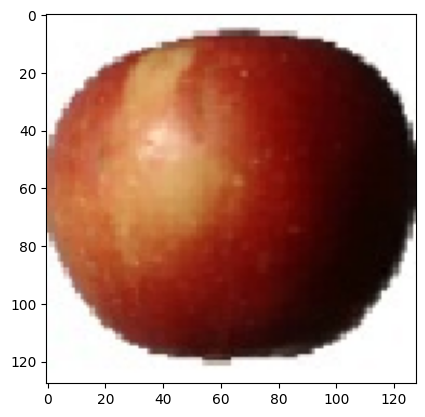

In [11]:
plt.imshow(random_brightness(img))

-----

In [12]:
def random_rgb_shift(img, max_shift=25):
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    
    # Generate random shifts for each channel
    shift_r = np.random.randint(-max_shift, max_shift + 1)
    shift_g = np.random.randint(-max_shift, max_shift + 1)
    shift_b = np.random.randint(-max_shift, max_shift + 1)
    
    # Apply the shifts to each channel, but do not modify pixels with value 255
    img_array[..., 0] = np.where(img_array[..., 0] < 240, np.clip(img_array[..., 0] + shift_r, 0, 255), img_array[..., 0])
    img_array[..., 1] = np.where(img_array[..., 1] < 240, np.clip(img_array[..., 1] + shift_g, 0, 255), img_array[..., 1])
    img_array[..., 2] = np.where(img_array[..., 2] < 240, np.clip(img_array[..., 2] + shift_b, 0, 255), img_array[..., 2])
    
    # Convert the numpy array back to a PIL image
    shifted_img = Image.fromarray(img_array.astype('uint8'), 'RGB')
    
    return shifted_img

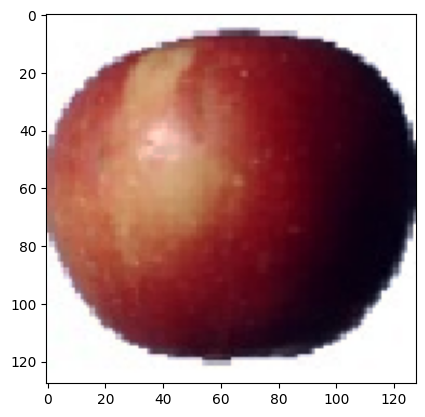

In [13]:
plt.imshow(random_rgb_shift(img))

-----

In [14]:
def random_stretch(img, max_stretch=0.07):
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Get the original dimensions
    original_height, original_width = img_array.shape[:2]
    
    # Generate random stretch factors for x and y axes
    stretch_x = 1 + np.random.uniform(-max_stretch, max_stretch)
    stretch_y = 1 + np.random.uniform(-max_stretch, max_stretch)
    
    # Calculate new dimensions
    new_width = int(original_width * stretch_x)
    new_height = int(original_height * stretch_y)
    
    # Resize the image
    stretched_img = img.resize((new_width, new_height), Image.LANCZOS)
    
    # Create a new white image with the original dimensions
    output_img = Image.new('RGB', (original_width, original_height), (255, 255, 255))
    
    # Calculate the position to paste the stretched image
    x_offset = (original_width - new_width) // 2
    y_offset = (original_height - new_height) // 2
    
    # Paste the stretched image onto the new white image
    output_img.paste(stretched_img, (x_offset, y_offset))
    
    return output_img

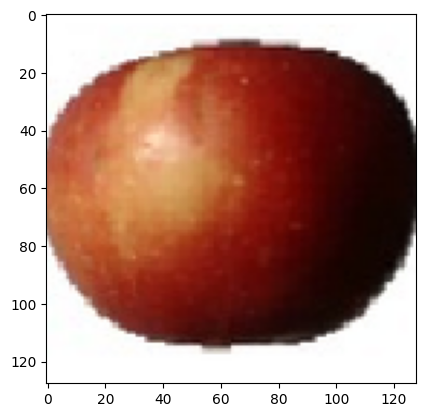

In [15]:
plt.imshow(random_stretch(img))

-----

In [16]:
def random_resize_and_repeat(img, min_scale=0.1, max_scale=0.5, num_repeats=10):
    # Convert the image to a numpy array
    img_array = np.array(img)
    
    # Create a white background image
    output_img = Image.new('RGB', img.size, (255, 255, 255))
    
    for _ in range(num_repeats):
        # Generate a random scale factor
        scale_factor = np.random.uniform(min_scale, max_scale)
        
        # Calculate new dimensions
        new_width = int(img.size[0] * scale_factor)
        new_height = int(img.size[1] * scale_factor)
        
        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.LANCZOS)
        
        # Generate random position
        x_offset = np.random.randint(0, img.size[0] - new_width + 1)
        y_offset = np.random.randint(0, img.size[1] - new_height + 1)
        
        # Create a mask to handle transparency
        mask = resized_img.convert("L").point(lambda x: 0 if x > 230 else 255, mode='1')
        
        # Paste the resized image onto the white background using the mask
        output_img.paste(resized_img, (x_offset, y_offset), mask)
    
    return output_img

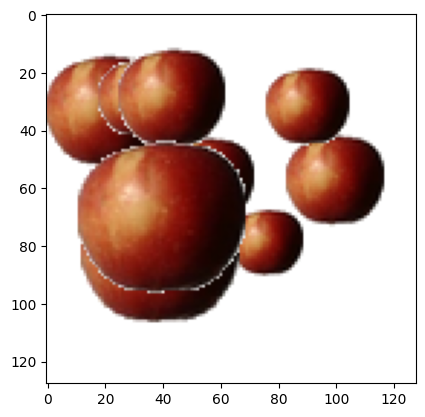

In [17]:
plt.imshow(random_resize_and_repeat(img))

#### Funzione lettura dataset

Si definisce la seguente funzione adibita a crare dei file .npz (numpy array) che serviranno successivamente a leggere l'intero dataset instantaneamente (invece che dover attendere lunghi tempi di attesa solo per caricare il dataset)

In [7]:
def preprocess_and_save(input_dir, output_file, show_images=False, augmentation=False):
    data = []
    # categoria generale (es mela)
    labels_1 = []
    # categoria specifica (es mela golden)
    labels_2 = []

    # support variables for plotting
    already_printed = []
    images_to_plot = []
    labels_to_plot = []

    class_names = sorted(os.listdir(input_dir))  # Assicura ordine costante delle classi
    for _, class_name in enumerate(class_names):
        class_dir = os.path.join(input_dir, class_name)

        # Use os.path.split to correctly handle path separators in a platform-independent way
        _, folder_name = os.path.split(class_dir)

        label_1 = labels_1_int[folder_name.split(' ')[0]]  # Access label_1
        
        folder_name = folder_name[-2:]
        if(folder_name.split(' ')[1] == ""):
            folder_name = labels_1_int[folder_name.split(' ')[0]] + " undefined"
        label_2 = labels_2_int[folder_name]                # Access label_2

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=(128, 128))  # Ridimensiona
            
            if(augmentation):
            # Genera un numero casuale da uno a 10
                random_number = random.randint(1, 10)
                # Switch del numero con case vuoti
                if random_number == 1:
                    pass  # Case vuoto
                elif random_number == 2:
                    img = translate_image(img)
                elif random_number == 3:
                    pass  # nothing
                elif random_number == 4:
                    img = random_brightness(img)
                elif random_number == 5:
                    pass  # Case vuoto
                elif random_number == 6:
                    img = random_stretch(img)
                elif random_number == 7:
                    img = random_resize_and_repeat(img)
                elif random_number == 8:
                    img = random_flip(img)
                elif random_number == 9:
                    img = random_rgb_shift(img)
                elif random_number == 10:
                    pass  # Case vuoto
            
            img_array = img_to_array(img)  # Convert the image to a NumPy array before resizing
            img_array = cv2.resize(img_array, (224, 224), interpolation=cv2.INTER_CUBIC)
            data.append(img_array)
            labels_1.append(label_1)
            labels_2.append(label_2)

            # Store image and label for plotting
            if label_2 not in already_printed:
                images_to_plot.append(img)
                labels_to_plot.append(folder_name)  # Use folder_name directly
                already_printed.append(label_2)

    if show_images:
        # Plot images and labels
        num_images = len(images_to_plot)
        num_cols = 10
        num_rows = (num_images + num_cols - 1) // num_cols

        plt.figure(figsize=(20, num_rows * 2))
        for i in range(num_images):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(images_to_plot[i])
            plt.title(labels_to_plot[i])
            plt.axis('off')
        plt.show()
        #save image to file
        plt.savefig('plot.png')

    # Converti in array numpy
    data = np.array(data)
    labels_1 = np.array(labels_1)
    labels_2 = np.array(labels_2)

    # Controllo se è train o validation per applicare lo shuffle
    if 'train' in input_dir:
        indices = np.random.permutation(len(data))  # Genera indici casuali
        data = data[indices]
        labels_1 = labels_1[indices]
        labels_2 = labels_2[indices]
        print("shuffle eseguito")
    else:
        print("shuffle solo per il train")

    # Salva i dati
    np.savez(output_file, x=data, y1=labels_1, y2=labels_2)

Di seguito viene chimata la funzione per creare i file di train/test/validation sets:

#### File train

Nota che in questo caso viene anche plottato un grafico che mostra un sample per ogni frutto disponibile nel nostro dataset. Questo plot è stato poi salvato in memoria di modo da porter comunque venire visualizzato anche quando non si esegue la funzione mostrata precedentemente:

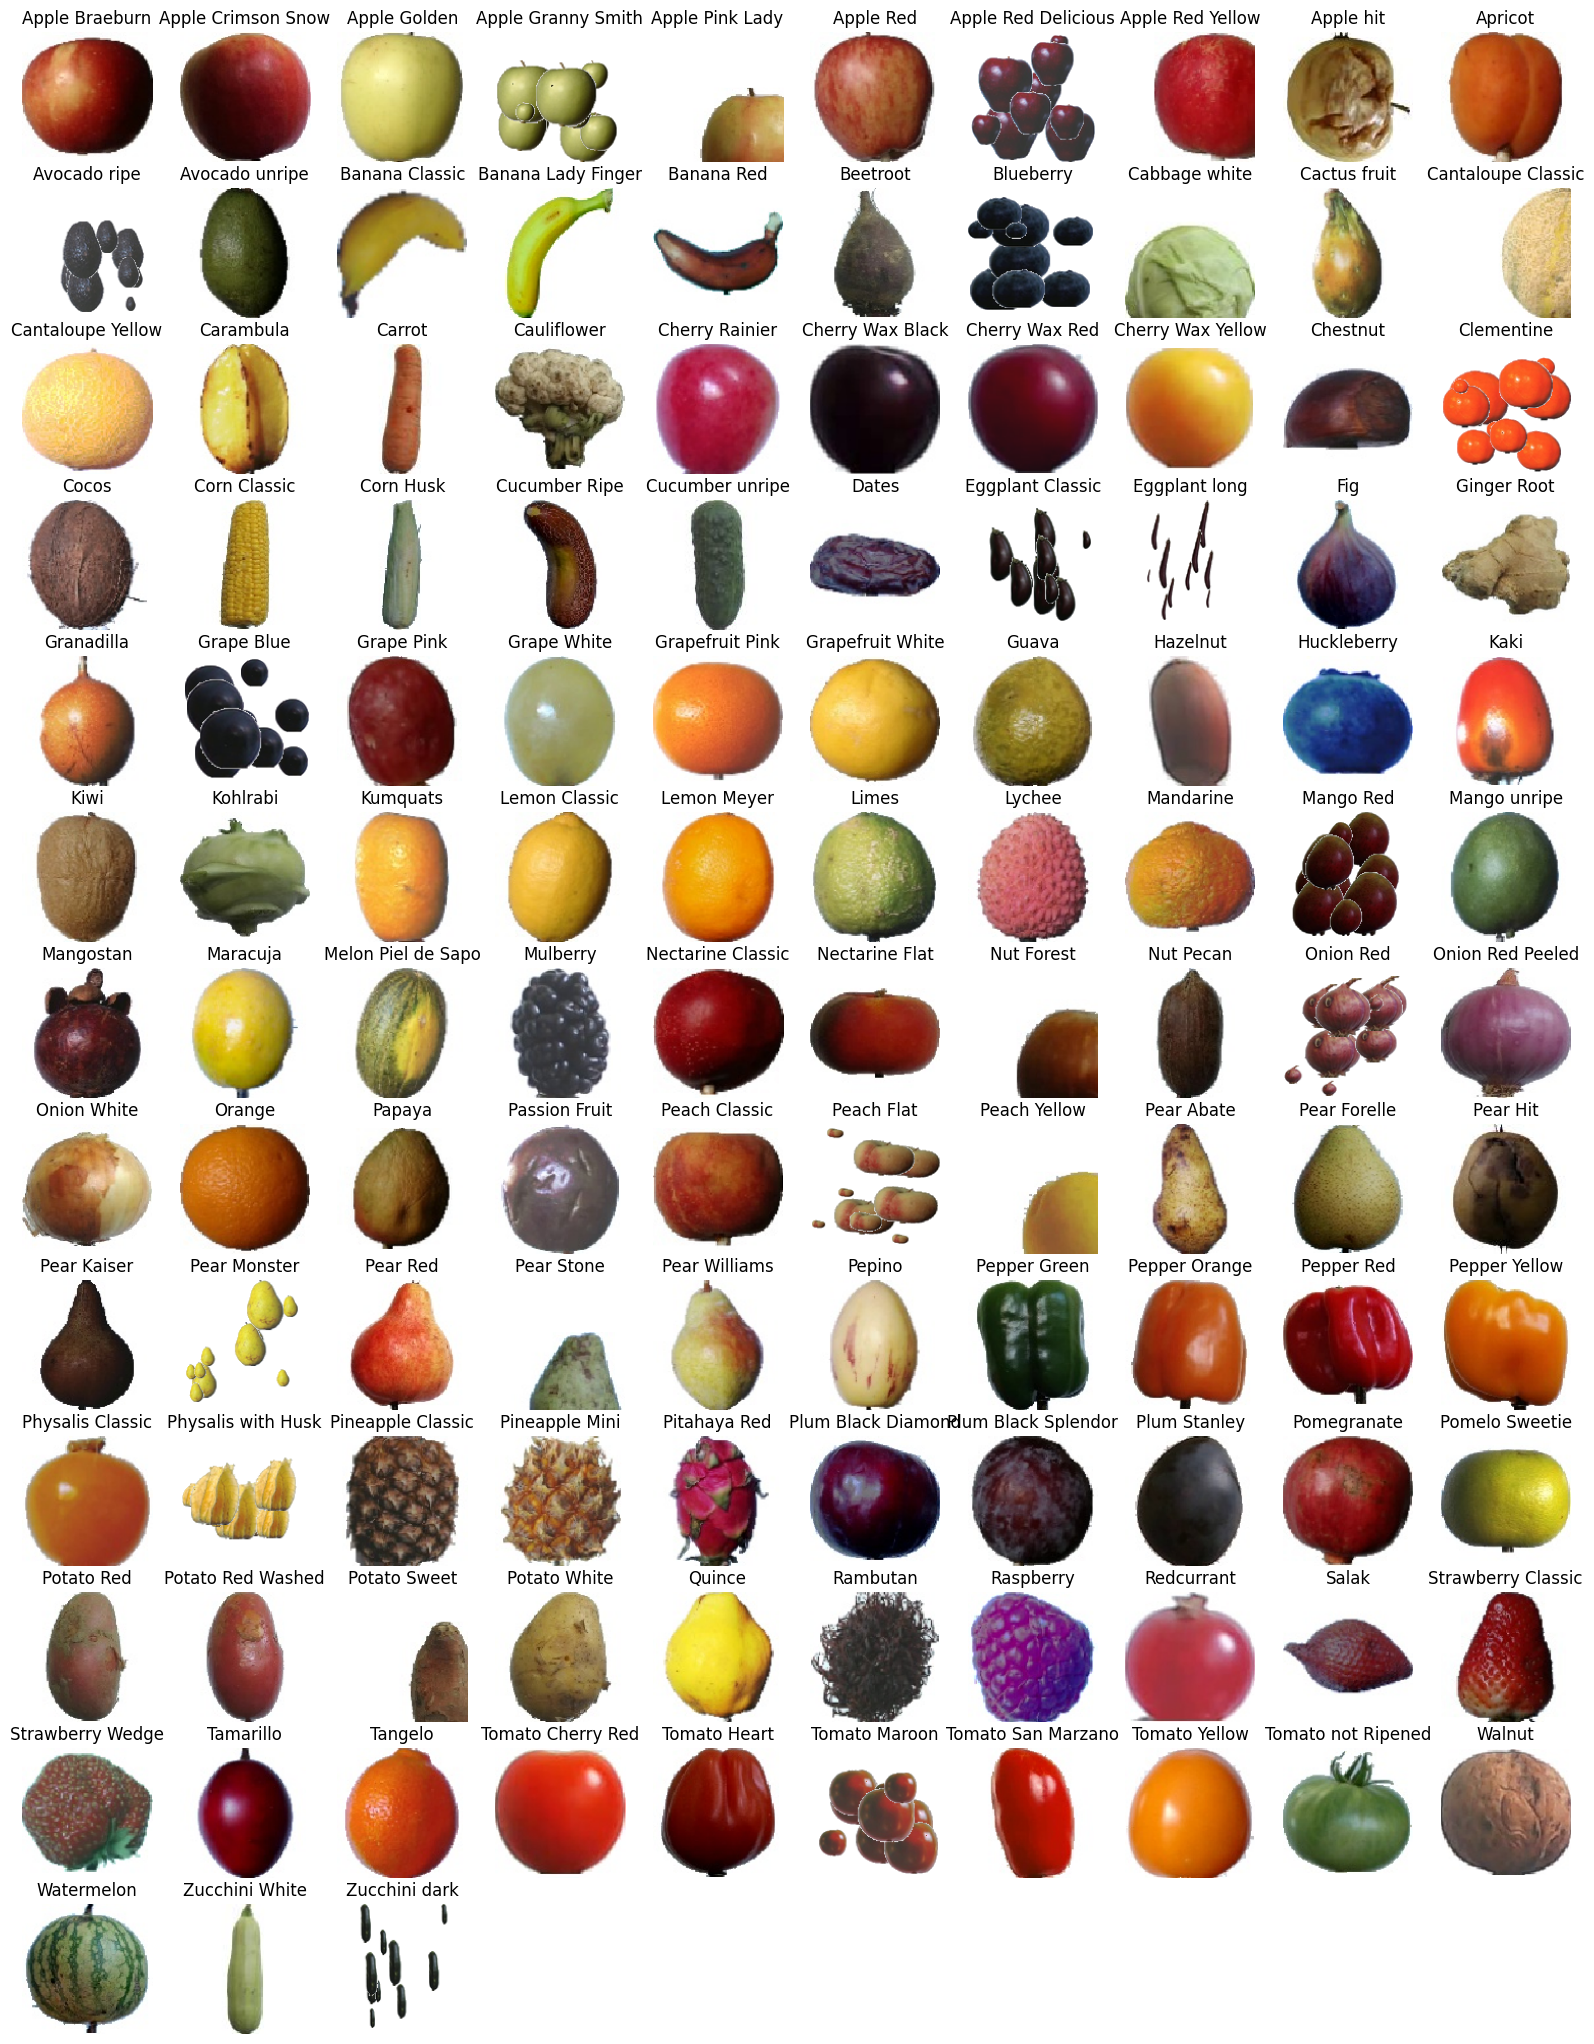

shuffle eseguito


<Figure size 640x480 with 0 Axes>

In [19]:
train_path = 'train_data_BIG.npz'
# check if npz file already exists
if not os.path.exists(train_path):
    preprocess_and_save(dataset_path+'train', train_path, show_images=True)
else:
    # plot local image using plt
    img = mpimg.imread('plot.png')
    # Create a figure with a large size
    fig, ax = plt.subplots(figsize=(12, 12))  # Adjust size as needed

    # Display the image
    ax.imshow(img)

    # Maximize the axis size by turning off the spines and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Show the image
    plt.show()

#### File validazione

scrittura file validation set con la stessa funzione

In [8]:
val_path = 'val_data_BIG.npz'
# check if npz file already exists
if not os.path.exists(val_path):
    preprocess_and_save(dataset_path+'val', val_path)

KeyError: ' 6'

#### File test

scrittura file test set con la stessa funzione

In [21]:
test_path = 'test_data_BIG.npz'
# check if npz file already exists
if not os.path.exists(test_path):
    preprocess_and_save(dataset_path+'test', test_path)

shuffle solo per il train


### Lettura file numpy array

Una volta che i file numpy array sono stati salvati è possibile leggerli direttamente, avere lo step precedente che ci salva tutti i dati in formato file e poi leggerli in questo step rende la lettura compilazione del file molto lenta (cosa che non ci interessa perchè dobbiamo farlo una sola volta) ma la lettura di tutto il dataset molto veloce.

In [22]:
# load train data
data_train = np.load('train_data_BIG.npz')
x_train, y1_train, y2_train = data_train['x'], data_train['y1'], data_train['y2']

# Load validation data
data_val = np.load('val_data_BIG.npz')
x_val, y1_val, y2_val = data_val['x'], data_val['y1'], data_val['y2']

# Load test data
data_test = np.load('test_data_BIG.npz')
x_test, y1_test, y2_test = data_test['x'], data_test['y1'], data_test['y2']

In [23]:
for i in range(len(y1_train)):
    print(f"train {i+1}: {labels_1_array[y1_train[i]]}, {labels_2_array[y2_train[i]]}")

train 1: Onion, Onion White
train 2: Rambutan, Rambutan
train 3: Avocado, Avocado ripe
train 4: Pepper, Pepper Green
train 5: Apple, Apple Crimson Snow
train 6: Lemon, Lemon Meyer
train 7: Lychee, Lychee
train 8: Guava, Guava
train 9: Potato, Potato Red
train 10: Fig, Fig
train 11: Plum, Plum Stanley
train 12: Pepper, Pepper Yellow
train 13: Orange, Orange
train 14: Granadilla, Granadilla
train 15: Grape, Grape Pink
train 16: Dates, Dates
train 17: Chestnut, Chestnut
train 18: Orange, Orange
train 19: Grape, Grape Blue
train 20: Pepper, Pepper Red
train 21: Quince, Quince
train 22: Kumquats, Kumquats
train 23: Mangostan, Mangostan
train 24: Pomelo, Pomelo Sweetie
train 25: Cabbage, Cabbage white
train 26: Pear, Pear Stone
train 27: Peach, Peach Yellow
train 28: Apricot, Apricot
train 29: Cauliflower, Cauliflower
train 30: Cactus, Cactus fruit
train 31: Kaki, Kaki
train 32: Ginger, Ginger Root
train 33: Strawberry, Strawberry Wedge
train 34: Nectarine, Nectarine Flat
train 35: Nectarine